In [1]:
# import
using Gurobi, CSV, DataFrames, JuMP, LinearAlgebra, Distributions, Random, Plots, Parquet, JSON3
gurobi_env = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-15


Gurobi.Env(Ptr{Nothing} @0x000000011fc33000, false, 0)

In [2]:
# load embeddings
df_emb_doc = Parquet.read_parquet("data_processed/rag-mini-wikipedia_document_embedding.parquet") |> DataFrame;
df_emb_qst = Parquet.read_parquet("data_processed/rag-mini-wikipedia_question_embedding.parquet") |> DataFrame;

In [3]:
emb_cols = [
    "bert-base-uncased",
    "multi-qa-mpnet-base-dot-v1",
    "hkunlp-instructor-large",
    "intfloat-e5-small-v2",
]

# encoding fix in julia
# doc
for cname in emb_cols
    col_sym = Symbol(cname)

    str_col = String.(df_emb_doc[!, col_sym])

    vec_col = [JSON3.read(s, Vector{Float32}) for s in str_col]

    df_emb_doc[!, col_sym] = vec_col
end

# q
for cname in emb_cols
    col_sym = Symbol(cname)

    str_col = String.(df_emb_qst[!, col_sym])

    vec_col = [JSON3.read(s, Vector{Float32}) for s in str_col]

    df_emb_qst[!, col_sym] = vec_col
end;

# Heuristic Approach
We first start by reconstructing a heuristic (i.e., Top-K Similarity Search) to approach the document retrieval problem in RAG. This serves as the **baseline optimization formulation**, which is equivalent to simply selecting the top-\(k\) most similar documents to a given query. It can be viewed as a **special case of a knapsack problem** where each document contributes a "value" equal to its cosine similarity score and all items have identical "costs" and a total capacity constraint k. The problem can be solved with the below formulation:


**Sets & Index**
- $I=\{1,\dots,n\}$: index set of candidate documents (single query)

**Parameters**
- $q\in\mathbb{R}^d$: query embedding  
- $\mu_i\in\mathbb{R}^d$: embedding of document $i\in I$  
- $s_i := \dfrac{q^\top \mu_i}{\|q\|_2\,\|\mu_i\|_2}$ (cosine similarity to the query);  
  if embeddings are unit-normalized, $s_i = q^\top \mu_i$  
- $k\in\{1,\dots,n\}$: exact number of documents to select (retrieval size)

**Decision Variables**
- $x_i\in\{0,1\}$: equals 1 if document $i$ is selected; 0 otherwise


$$
\begin{aligned}
\max_{x}\quad 
& \sum_{i\in I} s_i\, x_i
\\[6pt]
\text{s.t.}\quad
& \sum_{i\in I} x_i \;=\; k
\\[4pt]
& x_i \in \{0,1\}, \qquad \forall\, i\in I
\end{aligned}
$$



The objective maximizes the total cosine similarity between the selected documents and the query.  
The equality constraint enforces that exactly $k$ documents are chosen.  
This formulation is **mathematically equivalent** to the heuristic of sorting all documents by their similarity scores $s_i$ and picking the top $k$ entries.  
It thus provides a simple, interpretable baseline before introducing robust or multi-objective refinements.



In [4]:
# top k similarity
function select_top_k_by_similarity(
    df::DataFrame,
    emb_col::String,
    query_vec::AbstractVector{<:Real},
    k::Int;
)

    """
    select_top_k_by_similarity(df, emb_col, query_vec, k)

    Given:
    - `df`       :: DataFrame
    - `emb_col`  :: Symbol  (e.g., Symbol("bert-base-uncased"))
    - `query_vec`:: AbstractVector (embedding of the query)
    - `k`        :: Int (how many items to select)

    Builds and solves:

        max  ∑_i s_i x_i
        s.t. ∑_i x_i = k
            x_i ∈ {0,1}

    where s_i is similarity between query_vec and row i’s embedding
    (computed in this function, not pre-stored).

    Returns:
    - `selected_indices` :: Vector{Int}
    - `similarities`     :: Vector{Float64} (s_i for selected i)
    - `model`            :: JuMP.Model (in case you want duals, status, etc.)
    """

    n = nrow(df)

    # extract doc embeddings
    emb_list_raw = df[!, emb_col]              
    emb_list = [Float64.(v) for v in emb_list_raw]
    
    # query vector
    q = Float64.(query_vec)

    s = [dot(q, emb_list[i]) for i in 1:n]

    # model
    model = Model(() -> Gurobi.Optimizer(gurobi_env))
    set_silent(model)  

    @variable(model, x[1:n], Bin)
    @constraint(model, sum(x[i] for i in 1:n) == k)
    @objective(model, Max,
        sum(dot(q, emb_list[i]) * x[i] for i in 1:n)
    )

    optimize!(model)
    
    # solution extraction
    x_val = value.(x)
    selected_indices = [i for i in 1:n if x_val[i] > 0.5]

    return selected_indices, model
end

select_top_k_by_similarity (generic function with 1 method)

In [34]:
q_vec = df_emb_qst[1, "bert-base-uncased"] 
k = 5

idx, model = select_top_k_by_similarity(df_emb_doc, "bert-base-uncased", q_vec, 5);

In [36]:
df_emb_doc[idx, "passage"][2]

"Abraham Lincoln (February 12, 1809 â\u80\u93 April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, \"[I]n his short autobiography written " ⋯ 1063 bytes ⋯ "f the secessionist Confederate States of America in the American Civil War. He introduced measures that resulted in the abolition of slavery, issuing his Emancipation Proclamation in 1863 and promoting the passage of the Thirteenth Amendment to the Constitution in 1865."

# Enhancement Over Heuristic
Motivated by recent findings (https://arxiv.org/abs/2502.09017) that **diversity improves RAG performance** (e.g., MMR/FPS-style selection), we extend the top-\(k\) similarity heuristic to a **goal-based and bi-objective model** that (i) promotes **diversity** via a constraint on the *average pairwise cosine* among selected documents and (ii) lets the solver **adapt the number of selected items** by adding a sparsity penalty (useful when some queries are simple while others are complex).


**Sets & Index**
- $I=\{1,\dots,n\}$: index set of candidate documents (single query)

**Parameters**
- $q\in\mathbb{R}^d$: query embedding  
- $\mu_i\in\mathbb{R}^d$: embedding of document $i\in I$  
- $s_i := \dfrac{q^\top \mu_i}{\|q\|_2\,\|\mu_i\|_2}$ (cosine similarity to the query; if embeddings are unit-normalized, $s_i=q^\top \mu_i$)  
- $\operatorname{cos}_{ij} := \dfrac{\mu_i^\top \mu_j}{\|\mu_i\|_2\,\|\mu_j\|_2}$ (cosine similarity between documents $i$ and $j$)  
- $\rho_{\text{div}}\in[0,1]$: **diversity coverage ratio** (upper bound on the *average* pairwise cosine within the selected set)  
- $\lambda \ge 0$: sparsity regularization weight (penalizes the number of selected documents; larger $\lambda$ $\Rightarrow$ fewer documents)  

**Decision Variables**
- $x_i\in\{0,1\}$: equals 1 if document $i$ is selected; 0 otherwise  
- $y_{ij}\in[0,1]$: linearization variable representing co-selection ($y_{ij}\approx x_i x_j$) for all $i<j$


$$
\begin{aligned}
\max_{x,\,y}\quad 
& \sum_{i\in I} s_i\, x_i \;-\; \lambda \sum_{i\in I} x_i
\\[8pt]
\text{s.t.}\quad
& y_{ij} \;\le\; x_i, \qquad y_{ij} \;\le\; x_j, \qquad
  y_{ij} \;\ge\; x_i + x_j - 1, 
&& \forall\, i<j
\\[6pt]
& \sum_{i<j} \operatorname{cos}_{ij}\, y_{ij} \;\le\; \rho_{\text{div}} \sum_{i<j} y_{ij},
&& \text{(average pairwise cosine $\le \rho_{\text{div}}$)}
\\[6pt]
& x_i \in \{0,1\}, \quad y_{ij}\in[0,1],
&& \forall\, i<j,\ \forall\, i\in I
\end{aligned}
$$


**Interpretation.**  
- **Objective.** The term $\sum_i s_i x_i$ rewards query relevance (cosine to the query). The penalty $-\lambda \sum_i x_i$ **adapts the set size**: for simple queries (few strong matches), the model selects fewer items; for complex queries, it admits more items when their added relevance outweighs the penalty.  
- **Diversity (goal-based) constraint.** $\sum_{i<j} \operatorname{cos}_{ij} y_{ij} \le \rho_{\text{div}} \sum_{i<j} y_{ij}$ enforces that the **average** pairwise cosine among the selected documents does not exceed $\rho_{\text{div}}$. Lower $\rho_{\text{div}}$ $\Rightarrow$ stronger diversity (less redundancy).  
- **Linearization.** The $y_{ij}$ constraints are the standard McCormick links for $x_i x_j$, keeping the model as a MILP.  

This model is a **goal-based extension** of the top-\(k\) heuristic: rather than fixing $k$, it **learns** an appropriate set size via $\lambda$, while **constraining redundancy** through an interpretable average-cosine cap $\rho_{\text{div}}$, an idea aligned with MMR/FPS principles cited in the literature.

# A Robustness View
We now note that the diversity-augmented model above **does not control for uncertainty in embeddings**. Because document embeddings are **direct outputs of deep models**, each embedding can be written as  
$$\tilde{\mu}_i = \mu_i + \varepsilon_i,$$
where $\mu_i$ is the nominal output and $\varepsilon_i$ captures estimation noise/variance. In practice, different encoders $f$ map raw text into **different representation spaces**, so cosine similarities with a fixed query can shift substantially across models. For simplicity and identifiability, we assume the **query embedding is fixed** (treated as constant) and **only document embeddings vary**; this isolates uncertainty to the retrieved content while avoiding compounding ambiguity from moving both the query and documents simultaneously.

Below is the **robust (adversarial) formulation** that keeps the uncertainty set **generic**. It may be any **norm-ball** (e.g., $\ell_2,\ell_\infty,\ell_1$) or a **polyhedral** set (e.g., budgeted $k$-sparsity). We present the **max–min** problem as follows.

**Sets & Index**  
- $I=\{1,\dots,n\}$: candidate documents (single query episode)  
- $\{(i,j): i<j,\ i,j\in I\}$: unordered document pairs  

**Parameters**  
- $q\in\mathbb{R}^d$: fixed query embedding  
- $\mu_i\in\mathbb{R}^d$: nominal embedding of document $i$  
- $\mathcal{U}_i$: uncertainty set for document $i$, **user-chosen**, e.g.,  
  - **norm-based:** $\mathcal{U}_i=\{\tilde{\mu}_i:\ \|\tilde{\mu}_i-\mu_i\|_{*}\le \rho_i\}$  
  - **polyhedral:** $\mathcal{U}_i=\{\tilde{\mu}_i:\ A_i \tilde{\mu}_i \le b_i\}$ (incl. budgeted $k$-sparsity masks)  
- $\rho_{\mathrm{div}}\in[0,1]$: diversity coverage ratio (upper bound on average pairwise cosine)  
- $\lambda\ge 0$: sparsity (size) penalty weight  

**Similarity Definitions (with uncertain embeddings)**  
- Query–doc cosine under uncertainty:  
  $s_i(\tilde{\mu}_i) := \dfrac{q^\top \tilde{\mu}_i}{\|q\|_2\,\|\tilde{\mu}_i\|_2}.$  
- Doc–doc cosine under uncertainty:  
  $\mathrm{cos}_{ij}(\tilde{\mu}_i,\tilde{\mu}_j) := \dfrac{\tilde{\mu}_i^\top \tilde{\mu}_j}{\|\tilde{\mu}_i\|_2\,\|\tilde{\mu}_j\|_2}.$  

**Decision Variables**  
- $x_i\in\{0,1\}$: 1 if document $i$ is selected; 0 otherwise  
- $y_{ij}\in[0,1]$: co-selection linearization variable for pair $(i,j)$, approximating $x_i x_j$  

$$
\begin{aligned}
\max_{x,\,y}\ \min_{\{\tilde{\mu}_i\in\mathcal{U}_i\}_{i\in I}}\quad 
& \sum_{i\in I} s_i(\tilde{\mu}_i)\, x_i \;-\; \lambda \sum_{i\in I} x_i
\\[8pt]
\text{s.t.}\quad
& y_{ij} \;\le\; x_i,\quad y_{ij} \;\le\; x_j,\quad
  y_{ij} \;\ge\; x_i + x_j - 1, 
&& \forall\, i<j
\\[6pt]
& \max_{\tilde{\mu}_i\in\mathcal{U}_i,\ \tilde{\mu}_j\in\mathcal{U}_j}
  \sum_{i<j} \mathrm{cos}_{ij}(\tilde{\mu}_i,\tilde{\mu}_j)\, y_{ij}
  \;\le\; \rho_{\mathrm{div}} \sum_{i<j} y_{ij},
&& \text{(goal-based diversity under worst case)}
\\[6pt]
& x_i \in \{0,1\}, \quad y_{ij}\in[0,1],
&& \forall\, i\in I,\ \forall\, i<j
\end{aligned}
$$


**Interpretation.**  
- The **outer maximization** chooses a subset that is relevant (via query–doc cosine) while paying a **sparsity penalty** $\lambda\sum_i x_i$, letting the solver adapt set size to query complexity.  
- The **inner minimization** is an **adversary** choosing $\tilde{\mu}_i\in\mathcal{U}_i$ to **depress relevance** and **inflate redundancy** subject to the chosen uncertainty model (norm-based or polyhedral).  
- The **diversity goal** is imposed **robustly**: even under worst-case perturbations of embeddings, the **average pairwise cosine** of the selected set must not exceed $\rho_{\mathrm{div}}$.  

# Deterministic Tractable Reformulation
We now provide **deterministic reformulations** for the diversity-aware, sparsity-penalized model under two uncertainty families:
(1) a **norm-based** (dual-norm) set, and (2) a **polyhedral $k$-sparsity** set. 
To keep the model tractable and generic, we adopt the standard practice of **pre-normalizing embeddings** and using the **dot product** as the similarity surrogate; i.e., $s_i \approx q^\top \mu_i$ and $\mathrm{cos}_{ij}\approx \mu_i^\top \mu_j$. 
This avoids nonconvex denominators from cosine normalization while preserving ranking behavior.

### 1) Norm-based uncertainty set (dual-norm penalties, with geometry constant)

**Uncertainty.** For each $i$,
$$
\mathcal U_i \;=\; \{\ \tilde\mu_i=\mu_i+\Delta_i:\ \|\Delta_i\|\le \rho_i\ \},
$$
where $\|\cdot\|$ is any chosen **primal norm** (e.g., $\ell_2,\ell_\infty,\ell_1$). Its **dual norm**, denoted $\|\cdot\|_{*}$, is defined by $\|z\|_{*}=\max_{\|x\|\le 1} x^\top z$.

**Query–doc robustification.** Using support functions,
$$
\min_{\|\Delta_i\|\le\rho_i} q^\top(\mu_i+\Delta_i)
\;=\; q^\top\mu_i \;-\; \rho_i\,\|q\|_{*}.
$$

**Doc–doc robustification (pairwise redundancy) with geometry constant.**  
We bound
$$
\sup_{\substack{\|\Delta_i\|\le \rho_i\\ \|\Delta_j\|\le \rho_j}}
(\mu_i+\Delta_i)^\top(\mu_j+\Delta_j).
$$
**Step 1 (expand):**
$$
(\mu_i+\Delta_i)^\top(\mu_j+\Delta_j)
=\mu_i^\top\mu_j+\mu_i^\top\Delta_j+\mu_j^\top\Delta_i+\Delta_i^\top\Delta_j.
$$
**Step 2 (Hölder on mixed terms):**
$$
\mu_i^\top\Delta_j \le \|\mu_i\|_{*}\,\|\Delta_j\| \le \rho_j\,\|\mu_i\|_{*},
\qquad
\mu_j^\top\Delta_i \le \|\mu_j\|_{*}\,\|\Delta_i\| \le \rho_i\,\|\mu_j\|_{*}.
$$
**Step 3 (scale perturbation–perturbation term):** write $\Delta_i=\rho_i u$, $\Delta_j=\rho_j v$ with $\|u\|\le 1$, $\|v\|\le 1$. Then
$$
\Delta_i^\top\Delta_j=\rho_i\rho_j\,u^\top v
\;\le\; \rho_i\rho_j\,\kappa(\|\cdot\|),
$$
where the **geometry constant**
$$
\kappa(\|\cdot\|):=\max_{\|u\|\le 1,\ \|v\|\le 1} u^\top v
$$
depends only on the unit ball of the chosen norm.

**Deterministic reformulation (norm-based).**
$$
\begin{aligned}
\max_{x,\,y}\quad 
& \sum_{i\in I} \big(q^\top\mu_i - \rho_i\|q\|_{*}\big)\,x_i \;-\; \lambda \sum_{i\in I} x_i \\[4pt]
\text{s.t.}\quad
& y_{ij}\le x_i,\ y_{ij}\le x_j,\ y_{ij}\ge x_i+x_j-1,\quad \forall i<j \\[2pt]
& \sum_{i<j} \big(\mu_i^\top\mu_j + \rho_i\|\mu_j\|_{*} + \rho_j\|\mu_i\|_{*} + \rho_i\rho_j\,\kappa(\|\cdot\|)\big)\, y_{ij}
\ \le\ \rho_{\mathrm{div}}\sum_{i<j} y_{ij} \\[2pt]
& x_i\in\{0,1\},\ y_{ij}\in[0,1].
\end{aligned}
$$

**Interpretation (norm-based).**  
- Each item’s **relevance** shrinks by a dual-norm term $\rho_i\|q\|_{*}$ tied to the chosen primal norm.  
- **Redundancy** is conservatively inflated by mixed dual-norm terms plus the **geometry factor** $\kappa(\|\cdot\|)$ that captures how well two unit perturbations can align within that norm’s unit ball.  
- The model remains a **generic, norm-agnostic MILP**; plug in any norm, and penalties adapt via its dual and $\kappa$.

**$\kappa(\|\cdot\|)$ for norm choices considered in this work are**  
- $\kappa(\ell_2)=1$ (round Euclidean ball; perfect alignment bounded by 1).  
- $\kappa(\ell_\infty)=d$ (unit cube; all $d$ coordinates can align to 1 simultaneously).  
- $\kappa(\ell_1)=1$ (unit diamond; worst-case alignment achieved by concentrating mass on one coordinate).  

$\kappa(\|\cdot\|)$ is a **shape factor** of the norm ball: the “pointier” or more axis-aligned the ball, the more two perturbations can co-align, increasing worst-case redundancy. The rounder the ball, the smaller the alignment potential and the less conservative the bound.


In [7]:
include("./helper.jl")
using .Helper: attach_bound_logger!, compute_pairwise_scores, summarize_pairwise_scores

In [ ]:
# robust & diversity-aware selection
function norm_based_robust_retrieval(
    df::DataFrame,
    emb_col::String,
    query_vec::AbstractVector{<:Real},
    rho::AbstractVector{<:Float64},
    lambda::Float64,
    rho_div::Float64;
    norm_type::Symbol = :l2,          # :l2, :l1, :linf
    record_progress::Bool = true,
)

    n = nrow(df)
    @assert length(rho) == n "rho must have length n = nrow(df)"

    # doc embedding
    emb_list_raw = df[!, emb_col]
    emb_list = [Float64.(v) for v in emb_list_raw]

    # query embedding
    q = Float64.(query_vec)

    # kappa constant
    kappa = norm_type in (:l2, :l1) ? 1.0 :
            norm_type == :linf       ? length(emb_list[1]) * 1.0 :
            error("Unsupported norm_type: $norm_type")

    # dual norm ||·||_* depending on norm_type 
    dual_norm(v) = norm_type === :l2    ? norm(v, 2) :
                   norm_type === :l1    ? maximum(abs.(v)) :   # dual of l1 is linf
                   norm_type === :linf  ? sum(abs.(v)) :       # dual of linf is l1
                   error("Unsupported norm_type: $norm_type")

    dual_norm_q = dual_norm(q)

    # model
    model = direct_model(Gurobi.Optimizer(gurobi_env))
    set_silent(model)

    # attach logger 
    prog = record_progress ? Helper.attach_bound_logger!(model) : nothing

    # decision variables
    @variable(model, x[1:n], Bin)
    @variable(model, 0 <= y[1:n, 1:n] <= 1)

    # doc–doc linearization
    @constraint(model, [i=1:n-1, j=i+1:n], y[i, j] <= x[i])
    @constraint(model, [i=1:n-1, j=i+1:n], y[i, j] <= x[j])
    @constraint(model, [i=1:n-1, j=i+1:n], y[i, j] >= x[i] + x[j] - 1)

    # diversity LHS
    @expression(model, lhs_div,
        sum(
            (
                dot(emb_list[i], emb_list[j]) +
                rho[i] * dual_norm(emb_list[j]) +
                rho[j] * dual_norm(emb_list[i]) +
                rho[i] * rho[j] * kappa
            ) * y[i, j]
            for i in 1:n-1, j in i+1:n
        )
    )

    # diversity RHS
    @expression(model, rhs_div,
        rho_div * sum(y[i, j] for i in 1:n-1, j in i+1:n)
    )

    @constraint(model, lhs_div <= rhs_div)
    @constraint(model, sum(x[i] for i in 1:n) >= 1)
    # objective
    @objective(model, Max,
        sum(
            (dot(q, emb_list[i]) - rho[i] * dual_norm_q - lambda) * x[i]
            for i in 1:n
        )
    )

    optimize!(model)

    x_val = value.(x)
    selected_indices = [i for i in 1:n if x_val[i] > 0.5]

    if record_progress
        # prog is a NamedTuple (time, best_obj, best_bound)
        return selected_indices, model, prog
    else
        return selected_indices, model
    end
end;


In [29]:
emb_col = "bert-base-uncased"
rho_vec = fill(0.0007, nrow(df_emb_doc))
    
A, scores = compute_pairwise_scores(df_emb_doc, emb_col, rho_vec; norm_type = :l1)
summarize_pairwise_scores(scores)


Pairwise A[i,j] stats (i<j):
  n_pairs = 5118400
  min     = -0.011627525102655332
  q25     = 0.5740117213504935
  median  = 0.6569012628028432
  q75     = 0.7194069694951933
  max     = 1.0007715382896356
  mean    = 0.6397966175954357


In [26]:
q_vec = df_emb_qst[1, "bert-base-uncased"] 
rho_vec = fill(0.0007, nrow(df_emb_doc))  
lambda  =  0.72                
rho_div = 1.0

idx, model, prog = norm_based_robust_retrieval(df_emb_doc, "bert-base-uncased", q_vec, rho_vec, lambda, rho_div; norm_type=:l1);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-15


In [27]:
df_emb_doc[idx, "passage"]

6-element Vector{Union{Missing, String}}:
 "Millard Fillmore (January 7, 18" ⋯ 607 bytes ⋯ "hing Party and Whig candidate."
 "*As of 2007, Millard Fillmore r" ⋯ 187 bytes ⋯ " Johnson as his running mate)."
 "Abraham Lincoln (February 12, " ⋯ 1546 bytes ⋯ "t to the Constitution in 1865."
 "Stephen Grover Cleveland (March" ⋯ 673 bytes ⋯ "ies and inflationary policies."
 "*In Harry Turtledove's \"Great W" ⋯ 107 bytes ⋯ "ca on the Whig ticket in 1910."
 "#He was the first President to " ⋯ 132 bytes ⋯ "Roosevelt's presidential hero."

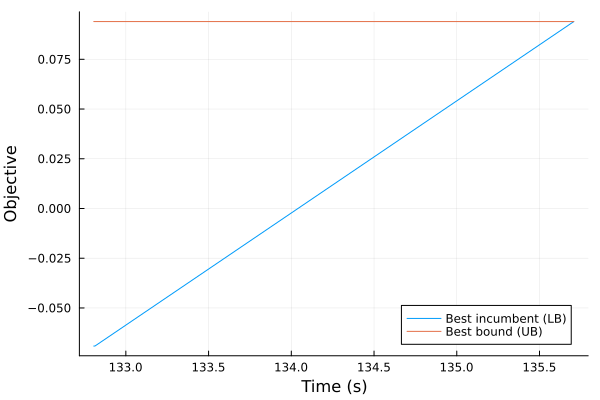

In [28]:
plot(
    prog.time,
    prog.best_obj;
    label = "Best incumbent (LB)",
    xlabel = "Time (s)",
    ylabel = "Objective",
    legend = :bottomright,
)
plot!(
    prog.time,
    prog.best_bound;
    label = "Best bound (UB)",
)


### 2) Polyhedral $k$-Sparsity Uncertainty (Budgeted Coordinate Erasures)

**Motivation.**  
In dense embeddings, **not every coordinate matters** for *directional closeness*. Many dimensions contribute negligibly to the cosine with the query or even introduce noise.  
The adversary can exploit this by **zeroing up to $k$ coordinates** that disproportionately determine similarity (either query–doc or doc–doc).  
This models encoder instability, pruning, or quantization noise, where minor directions are dropped without major semantic loss.

---

### (a) Definition of the Set

For each document $i$ with embedding $\mu_i \in \mathbb{R}^d$, introduce coordinate masks $z_{is}\in[0,1]$:

$$
\tilde{\mu}_{is} = \mu_{is}(1 - z_{is}), \qquad
\sum_{s=1}^d z_{is} \le k, \quad 0 \le z_{is} \le 1.
$$

The **polyhedral uncertainty set** is:

$$
\mathcal{U}_i^{(k)} = 
\left\{
\tilde{\mu}_i \in \mathbb{R}^d :
\exists\, z_i \in [0,1]^d,\ 
\sum_s z_{is} \le k,\ 
\tilde{\mu}_{is} = \mu_{is}(1 - z_{is})\ \forall s
\right\}.
$$

This set represents **budgeted coordinate erasures**, i.e., at most $k$ dimensions may be partially or fully removed.


### (b) Integrality and LP Equivalence

**From original inner minimization**
$$
\min_{\tilde{\mu}_i \in \mathcal U_i^{(k)}}\ q^\top \tilde{\mu}_i
\;=\;
\min_{z_i}\ \sum_{s=1}^d q_s\,\mu_{is}(1-z_{is})
\quad\text{s.t.}\quad
\sum_{s=1}^d z_{is}\le k,\ \ 0\le z_{is}\le 1.
$$

**Flip to equivalent maximization of the loss**
$$
\min_{z_i}\ \big(q^\top\mu_i - \sum_{s=1}^d q_s\mu_{is}\,z_{is}\big)
\;=\;
q^\top\mu_i \;-\; \max_{z_i}\ \sum_{s=1}^d q_s\mu_{is}\,z_{is}.
$$

**Keep only positive-impact coordinates**
Define $a_{is}:=(q_s\mu_{is})_{+}=\max\{q_s\mu_{is},0\}$. Then
$$
\max_{z_i}\ \sum_{s=1}^d q_s\mu_{is}\,z_{is}
\;=\;
\max_{z_i}\ \sum_{s=1}^d a_{is}\,z_{is},
$$
because the optimizer will set $z_{is}=0$ whenever $q_s\mu_{is}<0$.

**Primal (inner) LP**
$$
\begin{aligned}
\text{maximize}_{z_i}\quad
& \sum_{s=1}^d a_{is}\, z_{is}
\\
\text{subject to}\quad
& \sum_{s=1}^d z_{is} \le k
\\
& 0 \le z_{is} \le 1, \qquad s=1,\dots,d.
\end{aligned}
$$

Originally, one might impose $z_{is}\in\{0,1\}$ (exactly $k$ coordinates removed). However, relaxing this to $z_{is}\in[0,1]$ **does not change the optimum**, because the inner problem $\max_z \sum_s a_{is} z_{is}$ with $\sum_s z_{is}\le k$, $0\le z_{is}\le1$ is a **unit-weight 0–1 knapsack**. Its constraint matrix is **totally unimodular**, so the LP relaxation has **integral extreme points**. Therefore, the LP and IP are equivalent in optimal value. This guarantees exactness of the dualization step below.


### (c) Dual of the Query–Doc Robustification

For each document $i$, define $a_{is} := (q_s \mu_{is})_{+}$ (positive contribution).  
The inner adversarial problem is:

$$
\max_{z_i}\ \sum_s a_{is} z_{is}
\quad
\text{s.t. } \sum_s z_{is}\le k,\ 0\le z_{is}\le1.
$$

Dualizing this LP introduces $\pi_i \ge 0$ and $\alpha_{is}\ge 0$:

$$
\sum_s a_{is} z_{is}
\le
k\,\pi_i + \sum_s \alpha_{is}, \qquad
\alpha_{is} \ge a_{is} - \pi_i,\ \ \alpha_{is}\ge 0.
$$

Thus the **robust lower bound** on query–doc relevance is:

$$
q^\top \tilde{\mu}_i
\ge
q^\top \mu_i - \big(k\,\pi_i + \sum_s \alpha_{is}\big).
$$


### (d) Dual of the Doc–Doc Robustification

For document pair $(i,j)$ (one-sided perturbation on $j$), define $b_{ijs} := (-\mu_{is}\mu_{js})_{+}$.  
Then:

$$
\mu_i^\top \tilde{\mu}_j
\le
\mu_i^\top \mu_j + k\,\pi_{ij} + \sum_s \beta_{ijs},
$$

with dual variables $\pi_{ij}\ge 0,\ \beta_{ijs}\ge 0$ satisfying:

$$
\beta_{ijs} \ge b_{ijs} - \pi_{ij}, \quad \beta_{ijs}\ge 0.
$$

For two-sided erasures, apply this symmetrically or define $u_{ijs}$ for combined effects.


### (e) Deterministic Reformulation with Dual Constraints

Plugging the dual objectives back into the outer problem gives a **single-level optimization**:

$$
\begin{aligned}
\max_{x,\,y,\,\pi,\,\alpha,\,\pi_{ij},\,\beta}\quad 
& \sum_{i\in I} \Big(q^\top\mu_i - k\,\pi_i - \sum_{s=1}^d \alpha_{is}\Big)\, x_i
\;-\; \lambda \sum_{i\in I} x_i \\[4pt]
\text{s.t.}\quad
& \alpha_{is} \ge (q_s\mu_{is})_{+} - \pi_i,\quad \alpha_{is}\ge 0,\ \pi_i\ge 0,\quad \forall i,s \\[2pt]
& y_{ij}\le x_i,\ y_{ij}\le x_j,\ y_{ij}\ge x_i+x_j-1,\quad \forall i<j \\[2pt]
& \sum_{i<j} \Big(\mu_i^\top\mu_j + k\,\pi_{ij} + \sum_{s=1}^d \beta_{ijs}\Big)\, y_{ij}
\le \rho_{\mathrm{div}}\sum_{i<j} y_{ij} \\[2pt]
& \beta_{ijs} \ge (-\mu_{is}\mu_{js})_{+} - \pi_{ij},\quad \beta_{ijs}\ge 0,\ \pi_{ij}\ge 0,\quad \forall i<j,s \\[2pt]
& x_i\in\{0,1\},\ y_{ij}\in[0,1].
\end{aligned}
$$



### (f) Linearization to Obtain a Pure MILP

We introduce auxilary variables w, r, s to linearize the multiplicative relationship of decision variables in the above formulation.

$$
\begin{aligned}
\max_{x,\,y,\,\pi,\,\alpha,\,\pi_{ij},\,\beta,\,r,\,s,\,w}\quad 
& \sum_{i\in I} r_i \;-\; \lambda \sum_{i\in I} x_i
\\[6pt]
\text{s.t.}\quad
& r_i \;\le\; q^\top \mu_i \;-\; k\,\pi_i \;-\; \sum_{s=1}^d \alpha_{is}, && \forall i
\\
& \alpha_{is} \;\ge\; a_{is} - \pi_i,\ \ \alpha_{is}\ge 0,\ \ \pi_i\ge 0, && \forall i,\ \forall s
\\
& r_i \;\le\; M_i\, x_i,\ \ r_i\ge 0, && \forall i
\\[6pt]
& y_{ij} \;\le\; x_i,\ \ y_{ij} \;\le\; x_j,\ \ y_{ij} \;\ge\; x_i + x_j - 1, && \forall i<j
\\[6pt]
& s_{ij} \;\ge\; \mu_i^\top \mu_j \;+\; k\,\pi_{ij} \;+\; \sum_{s=1}^d \beta_{ijs}, && \forall i<j
\\
& \beta_{ijs} \;\ge\; b_{ijs} - \pi_{ij},\ \ \beta_{ijs}\ge 0,\ \ \pi_{ij}\ge 0,\ \ s_{ij}\ge 0, && \forall i<j,\ \forall s
\\[6pt]
& w_{ij} \;\le\; s_{ij},\ \ w_{ij} \;\le\; M_{ij}\, y_{ij},\ \ w_{ij} \;\ge\; s_{ij} - M_{ij}(1-y_{ij}),\ \ w_{ij}\ge 0, && \forall i<j
\\
& \sum_{i<j} w_{ij} \;\le\; \rho_{\mathrm{div}} \sum_{i<j} y_{ij}
\\[6pt]
& x_i \in \{0,1\},\ \ y_{ij}\in[0,1], && \forall i,\ \forall i<j
\\[8pt]
& \text{where } a_{is} := (q_s \mu_{is})_{+},\ \ b_{ijs} := (-\mu_{is}\mu_{js})_{+},\ \ M_i,\ M_{ij}\ \text{are valid big-}M\ \text{bounds.}
\end{aligned}
$$


### (g) Interpretation

- The adversary can **erase up to $k$ coordinates** per document, targeting those with the largest contribution to similarity.  
- This reflects the fact that **a few key coordinates dominate cosine similarity**, while most are redundant.  
- The resulting model is a **fully linear MILP**, exact under LP duality because the inner problem’s LP relaxation is tight.  
- Parameters:
  - $k$: level of adversarial sparsification (robustness strength),  
  - $\rho_{\mathrm{div}}$: desired diversity bound,  
  - $\lambda$: regularization on retrieval sparsity.


In [ ]:
# TODO

# Cutting Plane?